In [1]:
import pandas as pd
import glob
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import numpy as np

In [2]:
folder_name = "wm_load"
data_path = "../data/" + folder_name + "/full_dataset/*.csv"
csv_files = glob.glob(data_path)

In [3]:
def is_optimal_first(x):
    try:
        rewardMap = literal_eval(x.rewardMap)
        if x.isCatch or x.task_part != 'value training': return None
        return x.response0 == max(rewardMap, key=rewardMap.get).split(',')[0]
    except:
        return None
    
def optimal_score(x):
    try:
        rewardMap = literal_eval(x.rewardMap)
        if x.isCatch or x.task_part != 'value training': return None
        return max(rewardMap.values())
    except:
        return None

def is_optimal_second(x):
    try:
        rewardMap = literal_eval(x.rewardMap)
        subset = {k: v for k, v in rewardMap.items() if x.response0 in k}
        if x.isCatch or x.task_part != 'value training': return None
        return x.response1 == max(subset, key=subset.get).split(',')[1]
    except:
        return None
    
def reformat_rt(x):
    try:
        if type(literal_eval(str(x)))==int:
            return [literal_eval(str(x))]
        else:
            return literal_eval(str(x)) 
    except:
        return [None,None]   
    
def reformat_response(x):
    try:
        if '[' not in x:
            return [x]
        else:
            return literal_eval(str(x))
    except:
        return [None,None]  

In [19]:
filtered_data = []
excluded = []
sub = 0
bonus = {}
for f in csv_files:
    sub += 1
    df = pd.read_csv(f)
    subject = sub
    condition = df.loc[0]["assigned_condition"]
    rest_condition = df.loc[0]["rest"] 
    if 'bonus' in df:
        bonus[df.loc[0]["subject_id"]] = df.tail(2)['bonus'].iloc[0]
        # calculate exclusion criteria for each subject
        interactions = df['browser_interaction'][df['browser_interaction'].notnull()].iloc[-1].count("event")
        comprehension_retries = df.loc[(df['task_part'] == 'comp_question') & (df['correct'] == False)].shape[0]
        dots_missed = 0
        if rest_condition == True:
            dots_missed = df['numberMissed'].sum()
        task_timeouts = df[(df['trial_type'] == "revaluation") & (df['environment'] != 'space')]['timeout'].mean()
        test_timeouts = df[(df['task_part'] == "first stage test")]['timeout'].mean()
        block1_lasthalf_accuracy = df[(df['order'] == 1) & (df['task_part'] == 'value training') & (df['isCatch']==False)].tail(21)['correct'].mean()
        block2_lasthalf_accuracy = df[(df['order'] == 2) & (df['task_part'] == 'value training') & (df['isCatch']==False)].tail(21)['correct'].mean()
        beep_error = df[df['trial_type'] == 'html-slider-response'].tail(8)['error'].mean()
        
        if interactions > 20 or task_timeouts > 0.15 or comprehension_retries > 4 or block1_lasthalf_accuracy<0.75 or block2_lasthalf_accuracy<0.75 or (rest_condition == "rest" and dots_missed > 4) or beep_error > 4:
            excluded.append({'subject':subject, 'block1_second_half_accuracy':block1_lasthalf_accuracy, 'block2_second_half_accuracy':block2_lasthalf_accuracy, 'task_timeouts':task_timeouts, 'comprehension_retries':comprehension_retries, 'interactions':interactions, 'dots_missed': dots_missed, 'beep_error':beep_error})
        else:
            # keep only relevant columns
            filtered = df[['subject_id','task_part', 'rt', 'timeout', 'stimulus', 'response','environment','score', 'isCatch', 'correct', 'condition', 'order', 'rewardMap','trial_num', 'age', 'gender','rest']]
            filtered = filtered[filtered['task_part'].isin(['value training', 'revaluation','first stage test','second stage test'])]
            filtered['subject_id'] = sub
            # add task condition and age info
            filtered['subject_condition'] = condition
            filtered['rest'] = rest_condition
            #filtered['age'] = float(exact_ages[exact_ages['subject_id'] == int(subject)].iloc[0]['Age'])

            # reformatting trial_num, RT, and response data
            filtered['trial_num'] = filtered['trial_num'].astype('Int64') // 2
            rt_list = filtered['rt'].apply(lambda x: reformat_rt(x)).values.tolist()
            rt_df = pd.DataFrame(rt_list).add_prefix('rt')  
            filtered = filtered.reset_index().join(rt_df).drop('rt', axis=1)        
            response_list = filtered['response'].apply(lambda x: reformat_response(x)).values.tolist()
            response_df = pd.DataFrame(response_list).add_prefix('response')  
            filtered = filtered.reset_index().join(response_df).drop('response', axis=1)
            
            # compute is_optimal_first, is_optimal_second, and optimal_score for each trial
            first = filtered.apply(lambda x: is_optimal_first(x), axis=1)
            second = filtered.apply(lambda x: is_optimal_second(x), axis=1)
            filtered = filtered.merge(first.rename("is_optimal_first"),left_index=True, right_index=True)
            filtered = filtered.merge(second.rename("is_optimal_second"),left_index=True, right_index=True)
            filtered['optimal_score'] = filtered.apply(optimal_score, axis=1)
            
            filtered_data.append(filtered)

filtered_data = pd.concat(filtered_data, ignore_index=True)
filtered_data['categorical_age'] = pd.cut(filtered_data['age'], bins=[7,13,18,24], labels=['Children','Adolescents','Adults'])
# rename columns "order" to "block_order" and "condition" to "block_condition"
filtered_data = filtered_data.rename(columns={'order':'block_order', 'condition':'block_condition'})

excluded = pd.DataFrame(excluded)
excluded.to_csv('../data/' + folder_name + '/preprocessed/excluded.csv')
bonus

{'6664215e9a4fc14231f523c6': 3.0,
 nan: 4.0,
 '62b1e957d10fa7c323e0df84': 4.0,
 '61592ea07347e286bca1955f': 4.0,
 nan: 4.0,
 nan: 4.0,
 '64135f3a5f83c8b43e569213': 4.0,
 '66572731cb06ce43c72bdf8a': 4.0,
 '66377b92cc73b915298b1bf5': 4.0,
 '65f647c74af96460db093800': 4.0,
 nan: 4.0,
 '66952c67f557cc6b49a8d91f': 4.0,
 '666def2522abf8b4a768b3cb': 4.0,
 nan: 4.0,
 '664cef98bb2e4a28e1fce2cb': 4.0,
 '58d834cec207720001e2e750': 4.0,
 '6692463a3773ef328cdde1f0': 4.0,
 nan: 4.0,
 '59a07638bfd73c00010ea394': 4.0,
 '6688d16e085c316a7ced59c1': 4.0,
 '65a4333efc75f965e7fc0cb5': 4.0,
 nan: 4.0,
 nan: 4.0,
 nan: 4.0,
 nan: 4.0,
 '5fb5dfa5df577200090d9dc4': 4.0,
 '665099524d67a0c2cb38ee42': 4.0,
 '65e862f844f1b7a803bb3c5a': 3.0,
 '65f5a84b838dcc1ac14602f2': 4.0}

In [5]:
# To assess optimal choices during learning
learning_data = filtered_data[(filtered_data['task_part']=='value training')&(filtered_data['isCatch']==False)].copy() # keep only non-catch learning trials
learning_data['trial_num'] = learning_data.groupby(['subject_id', 'block_condition']).cumcount() + 1                  # reset trial number after removing catch 
learning_data['trial_bin'] = learning_data.groupby(['subject_id','block_order']).cumcount() // 5 * 5                  # get binned trial num for graphing smooth learning curve
learning_data = learning_data[learning_data['timeout']==False]                                                  # keep only trials where participants did not time out
learning_data['is_optimal'] = learning_data['score'] == learning_data['optimal_score']                          # binary optimal score metric for performance
learning_data.to_csv('../data/' + folder_name + '/preprocessed/learning_data1.csv')

# To assess age differences in first-stage vs second-stage choices
learning_data_2 = learning_data.copy().melt(
    id_vars=['subject_id','age','trial_num','block_condition','block_order'],
    value_vars=['is_optimal_first', 'is_optimal_second'],
    var_name='stage',
    value_name='optimal'
)
learning_data_2['stage'] = learning_data_2['stage'].replace({'is_optimal_first': 'First', 'is_optimal_second': 'Second'})
learning_data_2.to_csv('../data/' + folder_name + '/preprocessed/learning_data2.csv')

# To assess optimal choices during relearning
relearning_data = filtered_data[filtered_data['task_part']=='revaluation'].copy()
relearning_data['trial'] = relearning_data.groupby(['subject_id', 'stimulus'])['stimulus'].cumcount()   # Calculate trial number per second stage state
relearning_data.to_csv('../data/' + folder_name + '/preprocessed/relearning_data.csv')

In [6]:
# get metadata about each subject block (order, stimuli)
block_conditions = filtered_data.groupby(['subject_id','block_condition'],as_index=False).first()[['subject_id','block_condition','environment','block_order']]
block_conditions['block_condition'] = block_conditions['block_condition'].apply(lambda x: "Control" if x=='original' else "Revaluation")

# get age info for each subject
#demographics = filtered_data.groupby('subject_id').first()[['age','gender','categorical_age']]

learning_first_stage_accuracy = learning_data.groupby(['subject_id','block_condition']).tail(10).groupby(['subject_id','block_condition'])['is_optimal_first'].mean().reset_index()
last_10_accuracy = learning_data.groupby(['subject_id','block_condition']).tail(10).groupby(['subject_id','block_condition'])['is_optimal'].mean().reset_index()

In [7]:
filtered_data

,level_0,index,subject_id,task_part,timeout,stimulus,environment,score,isCatch,correct,...,rest,subject_condition,rt0,rt1,response0,response1,is_optimal_first,is_optimal_second,optimal_score,categorical_age
0,0,132,3,value training,False,./assets/img/ocean/catch/3.jpg,ocean,0.0,True,True,...,False,8,596.1,NaN,spaceBar,None,None,None,NaN,NaN
1,1,134,3,value training,False,./assets/img/ocean/memory/20.jpg,ocean,10.0,False,False,...,False,8,532.9,603.1,ArrowUp,ArrowRight,True,False,26.0,NaN
2,2,136,3,value training,False,./assets/img/ocean/memory/13.jpg,ocean,26.0,False,True,...,False,8,467.0,282.2,ArrowUp,ArrowLeft,True,True,26.0,NaN
3,3,138,3,value training,False,./assets/img/ocean/memory/20.jpg,ocean,5.0,False,False,...,False,8,686.5,408.6,ArrowDown,ArrowLeft,False,False,26.0,NaN
4,4,140,3,value training,False,./assets/img/ocean/memory/41.jpg,ocean,17.0,False,False,...,False,8,653.1,285.6,ArrowDown,ArrowRight,False,True,26.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3835,155,480,48,second stage test,False,./assets/img/canyon/animals/lion.jpg,canyon,0.0,NaN,True,...,False,5,424.0,NaN,ArrowLeft,None,None,None,NaN,NaN
3836,156,482,48,second stage test,False,./assets/img/canyon/animals/giraffe.jpg,canyon,0.0,NaN,True,...,False,5,2650.9,NaN,ArrowLeft,None,None,None,NaN,NaN
3837,157,484,48,second stage test,False,./assets/img/canyon/animals/giraffe.jpg,canyon,0.0,NaN,True,...,False,5,877.1,NaN,ArrowLeft,None,None,None,NaN,NaN
3838,158,486,48,second stage test,False,./assets/img/canyon/animals/giraffe.jpg,canyon,0.0,NaN,True,...,False,5,596.2,NaN,ArrowLeft,None,None,None,NaN,NaN


In [8]:
def get_reval_magnitude(filtering, name):
    before = filtered_data[(filtered_data['task_part'] == 'value training') & filtering & (filtered_data['isCatch']==False)].groupby('subject_id').tail(10).copy()
    after = filtered_data[(filtered_data['task_part'] == 'first stage test') & filtering].copy()
    reward_map_before = before.groupby('subject_id').first()['rewardMap'].apply(lambda x: literal_eval(x))
    correct_response = reward_map_before.apply(lambda x: max(x, key=x.get).split(",")[0])
    true_accuracy_before = before.groupby('subject_id')['correct'].mean()
    before['correct'] = before.apply(lambda x: x.response0 == correct_response[x.subject_id], axis=1)
    after['correct'] = after.apply(lambda x: x.response0 == correct_response[x.subject_id], axis=1)
    correct_before = before.groupby('subject_id')['correct'].mean()
    match_after = after.groupby('subject_id')['correct'].mean()
    reval_magnitude = correct_before - match_after
    single_reval = after.groupby('subject_id').head(1).apply(lambda x: x.response0 != correct_response[x.subject_id], axis=1)
    single_reval.index = after.groupby('subject_id').head(1)['subject_id']
    return reval_magnitude.rename(name), true_accuracy_before.rename(name+'_correct_before'), single_reval.rename(name+'_single')

reval_reval_magnitude, reval_correct_before, reval_single = get_reval_magnitude(filtered_data['block_condition']=='revaluation', 'Revaluation')
control_reval_magnitude, control_correct_before, control_single = get_reval_magnitude(filtered_data['block_condition']=='original', 'Control')
first_reval_magnitude, _, _ = get_reval_magnitude(filtered_data['block_order']==1, 'first')
second_reval_magnitude, _, _ = get_reval_magnitude(filtered_data['block_order']==2, 'second')
reval_results = pd.concat([reval_reval_magnitude, control_reval_magnitude, first_reval_magnitude, second_reval_magnitude, reval_correct_before, control_correct_before, reval_single, control_single], axis=1)
#reval_results = pd.merge(reval_results,demographics, on="subject_id")

In [9]:
reval_results['block_condition'] = 'Revaluation'
participant_data_processed = reval_results[['block_condition']]
participant_data_processed['reval_score'] = reval_results['Revaluation']
participant_data_processed['reval_single'] = reval_results['Revaluation_single']
participant_data_processed['last_10_accuracy'] = reval_results['Revaluation_correct_before']
participant_data_processed = participant_data_processed.reset_index()
control = reval_results.reset_index()
control['block_condition'] = 'Control'
control['reval_score'] = control['Control']
control['reval_single'] = control['Control_single']
control['last_10_accuracy'] = control['Control_correct_before']
participant_data_processed = pd.concat([participant_data_processed,control[['subject_id', 'block_condition', 'reval_score','last_10_accuracy','reval_single']]])
participant_data_processed = participant_data_processed.merge(block_conditions,on=['subject_id','block_condition'])
participant_data_processed = participant_data_processed.set_index('subject_id')

reval_accuracy = filtered_data[filtered_data['task_part'] == 'revaluation'].groupby(["subject_id","block_condition"])['correct'].mean().reset_index()
reval_accuracy['block_condition'] = reval_accuracy['block_condition'].apply(lambda x: "Control" if x=='original' else "Revaluation")
reval_accuracy = reval_accuracy.rename(columns={'correct': 'reval_accuracy'})
participant_data_processed = pd.merge(participant_data_processed,reval_accuracy,on=['subject_id','block_condition'])

second_stage_test = filtered_data[filtered_data['task_part'] == 'second stage test'].groupby(["subject_id","block_condition"])['correct'].mean().reset_index()
second_stage_test['block_condition'] = second_stage_test['block_condition'].apply(lambda x: "Control" if x=='original' else "Revaluation")
second_stage_test = second_stage_test.rename(columns={'correct': 'second_stage_test'})
participant_data_processed = pd.merge(participant_data_processed,second_stage_test,on=['subject_id','block_condition'])

rest = filtered_data.groupby(['subject_id']).first()['rest']
participant_data_processed= pd.merge(participant_data_processed,rest,on=['subject_id'])

participant_data_processed.to_csv('../data/' + folder_name + '/preprocessed/data.csv')
participant_data_processed

/var/folders/x_/2rt9php14l77064t1fz9yq800000gp/T/ipykernel_9528/4232516589.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participant_data_processed['reval_score'] = reval_results['Revaluation']
/var/folders/x_/2rt9php14l77064t1fz9yq800000gp/T/ipykernel_9528/4232516589.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participant_data_processed['reval_single'] = reval_results['Revaluation_single']
/var/folders/x_/2rt9php14l77064t1fz9yq800000gp/T/ipykernel_9528/4232516589.py:5: SettingWithCopyWarning:

,subject_id,block_condition,reval_score,reval_single,last_10_accuracy,environment,block_order,reval_accuracy,second_stage_test,rest
0,3,Revaluation,0.00,False,1.0,ocean,1.0,0.777778,0.500,False
1,3,Control,0.25,True,1.0,canyon,2.0,0.722222,0.875,False
2,5,Revaluation,0.50,True,1.0,ocean,1.0,0.833333,0.375,True
3,5,Control,0.00,False,1.0,canyon,2.0,0.888889,1.000,True
4,7,Revaluation,1.00,True,1.0,canyon,2.0,0.777778,1.000,False
5,7,Control,0.00,False,1.0,ocean,1.0,1.000000,1.000,False
6,8,Revaluation,0.00,False,1.0,ocean,1.0,0.833333,1.000,True
7,8,Control,0.00,False,1.0,canyon,2.0,0.777778,1.000,True
8,9,Revaluation,0.15,True,0.8,canyon,2.0,0.722222,0.250,True
9,9,Control,0.00,False,1.0,ocean,1.0,0.944444,1.000,True


Text(0.5, 1.0, 'Revaluation Score by Rest and Block Condition')

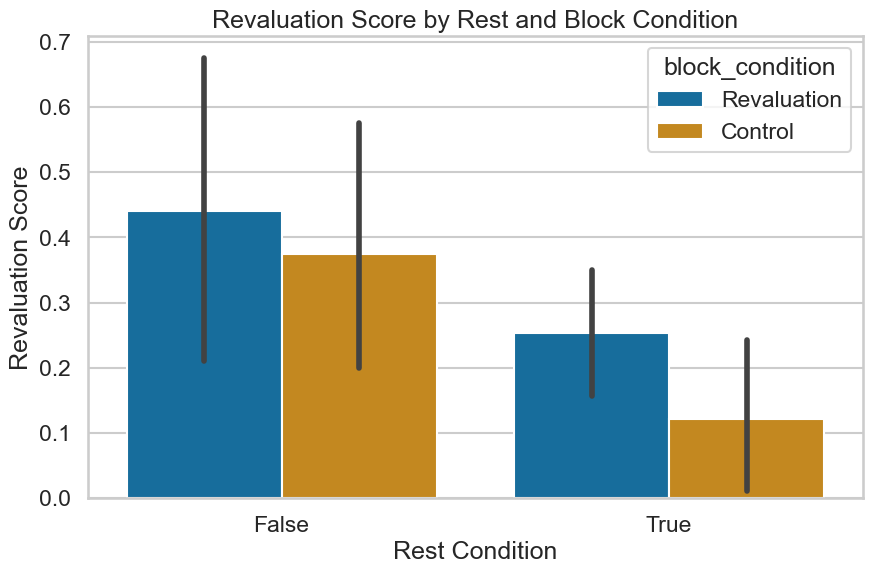

In [11]:
# make a bar plot, with reval_score on the y axis and block_condition on the x axis. Split by rest = True or False
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_palette("colorblind")
plt.figure(figsize=(10, 6))
sns.barplot(x='rest', y='reval_score', data=participant_data_processed, hue='block_condition')
plt.xlabel('Rest Condition')
plt.ylabel('Revaluation Score')
plt.title('Revaluation Score by Rest and Block Condition')
